In [41]:
import os
import random
import copy
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

seed = 449
random.seed(seed)
torch.manual_seed(seed)
writer = SummaryWriter(flush_secs=20)

# in cmd: tensorboard --logdir runs
# http://localhost:6006/#

In [42]:
batch_size = 128
image_size = 32
nc = 3      # number of channels in training image
nz = 128    # latent vector size

# size of feature maps in generator and discriminator
ngf = 64
ndf = 64

num_epochs = 1024
lr = 0.0002
beta1 = 0.5
ngpu = 1
smoothed = True
noised = True

path = "models/CatGAN/" + str(num_epochs) + "ep_" + str(ngf) + "nf_" + str(nz) + "nz_"

if (smoothed):
    path += "smoothed_"
if (noised):
    path += "noised_"

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


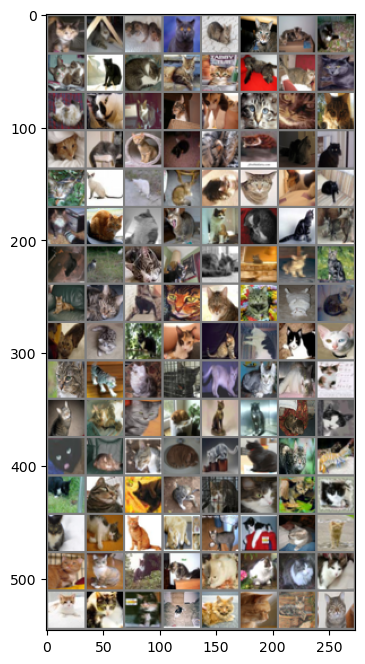

In [43]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# trainset = torch.utils.data.ConcatDataset([trainset, testset])

cat_idxs = np.where((np.array(trainset.targets) == 3))[0]
catset = torch.utils.data.Subset(trainset, cat_idxs)
catloader = torch.utils.data.DataLoader(catset, batch_size=batch_size, shuffle=True, num_workers=2)

# functions to show an image
def imshow(img, title=""):
    img = img / 2 + 0.5     # unnormalize
    img = img.numpy()
    plt.figure(figsize=(8,8))
    plt.title(title)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
def imsave(img, path):
    img = img / 2 + 0.5
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))
    path = path + "-image.png"
    plt.imsave(path, img)

dataiter = iter(catloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

# imshow(torchvision.utils.make_grid(images + (torch.randn(images.shape) * 0.1)))
# writer.add_image("training_images", torchvision.utils.make_grid(images))
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [44]:
# custom weights init from DCGAN paper
# TODO: try other initializations too
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [45]:
# original discriminator, modified to work with 32x32 images
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        self.net = nn.Sequential(
            # nc x 32 x 32 input
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # ndf x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # ndf*2 x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # ndf*4 x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.net(input)

path += "default-D_"

In [46]:
# class Discriminator(nn.Module):
#     def __init__(self, ngpu):
#         super().__init__()
#         self.ngpu = ngpu
#         self.net = nn.Sequential(
#             # nc x 32 x 32 input
#             nn.Conv2d(nc, ndf*2, 4, 2, 1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             # ndf x 16 x 16
#             nn.Conv2d(ndf*2, ndf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             # ndf*2 x 8 x 8
#             nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # ndf*4 x 4 x 4
#             nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
#         )
#     def forward(self, input):
#         return self.net(input)

In [47]:
# # original generator, modified to work with 32x32 images
# class Generator(nn.Module):
#     def __init__(self, ngpu):
#         super(Generator, self).__init__()
#         self.ngpu = ngpu
#         self.net = nn.Sequential(
#             # input is Z, going into a convolution
#             nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
#             nn.BatchNorm2d(ngf * 4),
#             nn.ReLU(True),
#             # nn.LeakyReLU(0.2, inplace=True),
#             # state size. ``(ngf*4) x 4 x 4``
#             nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 2),
#             nn.ReLU(True),
#             # nn.LeakyReLU(0.2, inplace=True),
#             # state size. ``(ngf*2) x 8 x 8``
#             nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf),
#             nn.ReLU(True),
#             # nn.LeakyReLU(0.2, inplace=True),
#             # state size. ``(ngf) x 16 x 16``
#             nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
#             nn.Tanh()
#             # state size. ``(nc) x 32 x 32``
#         )

#     def forward(self, x):
#         return self.net(x)

# # path = "models/CatGAN/" + str(num_epochs) + "ep_" + str(ngf) + "nf_" + str(nz) + "nz_Gdefault"
# path += "default-G.pt"

In [48]:
# class Generator(nn.Module):
#     def __init__(self, ngpu):
#         super(Generator, self).__init__()
#         self.ngpu = ngpu
#         self.net = nn.Sequential(
#             # input is Z, going into a convolution
#             nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
#             nn.BatchNorm2d(ngf * 4),
#             nn.ReLU(True),
#             # nn.LeakyReLU(0.2, inplace=True),
#             # state size. ``(ngf*4) x 4 x 4``
#             nn.ConvTranspose2d(ngf * 4, ngf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 2),
#             nn.ReLU(True),
#             # nn.LeakyReLU(0.2, inplace=True),
#             # state size. ``(ngf*2) x 8 x 8``
#             nn.ConvTranspose2d( ngf * 4, ngf, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf),
#             nn.ReLU(True),
#             # nn.LeakyReLU(0.2, inplace=True),
#             # state size. ``(ngf) x 16 x 16``
#             nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
#             nn.Tanh()
#             # state size. ``(nc) x 32 x 32``
#         )

#     def forward(self, x):
#         return self.net(x)

# path = "models/CatGAN/" + str(num_epochs) + "ep_" + str(ngf) + "nf_" + str(nz) + "nz_DLReLU-GReLU-block2outngfx4.pt"
# path += "block2outngfx4-G"

In [49]:
# best modification to generator layers found so far
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu

        self.relu = nn.ReLU(True)
        self.cvt1 = nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf * 4)
        
        self.cvt2 = nn.ConvTranspose2d(ngf * 4, ngf * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf * 4)

        self.cvt3 = nn.ConvTranspose2d(ngf * 4, ngf, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf)

        self.cvt4 = nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.cvt1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.cvt2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.cvt3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.cvt4(x)
        x = self.tanh(x)
        return x

# path = "models/CatGAN/" + str(num_epochs) + "ep_" + str(ngf) + "nf_" + str(nz) + "nz_DLReLU-GReLU-block2outngfx4-smoothing-shuffled-noised.pt"
path += "block2outngfx4-G.pt"

In [50]:
# class Generator(nn.Module):
#     def __init__(self, ngpu):
#         super(Generator, self).__init__()
#         self.ngpu = ngpu

#         self.relu = nn.ReLU(True)
#         self.cvt1 = nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False)
#         self.bn1 = nn.BatchNorm2d(ngf * 8)
        
#         self.cvt2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)
#         self.bn2 = nn.BatchNorm2d(ngf * 4)

#         self.cvt3 = nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)
#         self.bn3 = nn.BatchNorm2d(ngf * 2)

#         self.cvt4 = nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False)
#         self.tanh = nn.Tanh()

#     def forward(self, x):
#         x = self.cvt1(x)
#         x = self.bn1(x)
#         x = self.relu(x)

#         x = self.cvt2(x)
#         x = self.bn2(x)
#         x = self.relu(x)

#         x = self.cvt3(x)
#         x = self.bn3(x)
#         x = self.relu(x)

#         x = self.cvt4(x)
#         x = self.tanh(x)
#         return x

# path = "models/CatGAN/" + str(num_epochs) + "ep_" + str(ngf) + "nf_" + str(nz) + "nz_DLReLU-GReLU-outs842nc.pt"
# path += "outs842nc-G"

In [51]:
# class Generator(nn.Module):
#     def __init__(self, ngpu):
#         super(Generator, self).__init__()
#         self.ngpu = ngpu
#         self.net = nn.Sequential(
#             # input is Z, going into a convolution
#             nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
#             nn.BatchNorm2d(ngf * 8),
#             nn.ReLU(True),
#             # nn.LeakyReLU(0.2, inplace=True),
#             # state size. ``(ngf*4) x 4 x 4``
#             nn.ConvTranspose2d(ngf * 8, ngf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 2),
#             nn.ReLU(True),
#             # nn.LeakyReLU(0.2, inplace=True),
#             # state size. ``(ngf*2) x 8 x 8``
#             nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf),
#             nn.ReLU(True),
#             # nn.LeakyReLU(0.2, inplace=True),
#             # state size. ``(ngf) x 16 x 16``
#             nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
#             nn.Tanh()
#             # state size. ``(nc) x 32 x 32``
#         )

#     def forward(self, x):
#         return self.net(x)

# path = "models/CatGAN/" + str(num_epochs) + "ep_" + str(ngf) + "nf_" + str(nz) + "nz_DLReLU-GReLU-ngfx8.pt"
# path += "block1outngfx8-G"

In [52]:
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)

Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

In [53]:
netG = Generator(ngpu).to(device)
netG.apply(weights_init)

# noise = torch.randn(batch_size, nz, 1, 1, device=device)
# print(noise.shape)
# fakes = netG(noise)
# fakes = fakes.cpu()
# print(fakes.shape)

# imshow(torchvision.utils.make_grid(fakes))

Generator(
  (relu): ReLU(inplace=True)
  (cvt1): ConvTranspose2d(128, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cvt2): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cvt3): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cvt4): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tanh): Tanh()
)

In [54]:
img_list = []
G_losses = []
D_losses = []
saved_gens = [copy.deepcopy(netG)]

iters = 0

if (smoothed):
    real = 0.9
    fake = 0.1
else:
    real = 1.
    fake = 0.

loss_fn = nn.BCELoss()
fixed_noise = torch.randn(32, nz, 1, 1, device=device)
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

netD.train()
netG.train()

for epoch in tqdm(range(num_epochs)):
    noise_stdev = (0.1 - (epoch/(num_epochs*10)))
    for i, data in enumerate(catloader):
        ################################
        # Update Discriminator
        netD.zero_grad()
        images = data[0].to(device)
        
        # add noise to images
        if (noised):
            images = images + (torch.randn(images.shape, device=device) * noise_stdev)

        b_size = images.shape[0]
        labels = torch.full((b_size,), real, dtype=torch.float, device=device)

        # Discriminator with real images
        output = netD(images).view(-1)
        lossD_real = loss_fn(output, labels)
        lossD_real.backward()
        D_x = output.mean().item()

        # Generate fake images
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fakes = netG(noise)
        labels.fill_(fake)
        
        # add noise to fakes
        if (noised):
            fakes = fakes + (torch.randn(fakes.shape, device=device) * noise_stdev)
        
        # Classify fakes with Discriminator
        output = netD(fakes.detach()).view(-1)
        lossD_fake = loss_fn(output, labels)
        lossD_fake.backward()
        # D_G_z1 = output.mean().item()

        lossD = lossD_real + lossD_fake
        optimizerD.step()
        ################################
        # Update Generator
        netG.zero_grad()
        labels.fill_(real)

        # add noise to fakes
        if (noised):
            fakes = fakes + (torch.randn(fakes.shape, device=device) * noise_stdev)
        
        # Classify fakes with updated Discriminator
        output = netD(fakes).view(-1)
        lossG = loss_fn(output, labels)
        lossG.backward()
        # D_G_z2 = output.mean().item()
        optimizerG.step()

        # Training Stats
        if iters % 100 == 0:
            # print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
            #       % (epoch, num_epochs, i, len(trainloader),
            #          lossD.item(), lossG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            # G_losses.append(lossG.item())
            # D_losses.append(lossD.item())
            writer.add_scalar("loss/gen", lossG, iters)
            writer.add_scalar("loss/discrim", lossD, iters)

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 100 == 0) or ((epoch == num_epochs-1) and (i == len(trainloader)-1)):
            with torch.no_grad():
                generated = netG(fixed_noise).detach().cpu()
            img_list.append(torchvision.utils.make_grid(generated))
            writer.add_image("generated_images", torchvision.utils.make_grid(generated) / 2 + 0.5, iters)
            saved_gens.append(copy.deepcopy(netG))
        iters += 1

writer.flush()
writer.close()

netD.eval()
netG.eval()
torch.save(saved_gens[-1].state_dict(), path)

100%|██████████| 1024/1024 [1:33:10<00:00,  5.46s/it]


In [55]:
# netD.eval()
# netG.eval()
# torch.save(saved_gens[-1].state_dict(), path)

MovieWriter ffmpeg unavailable; using Pillow instead.


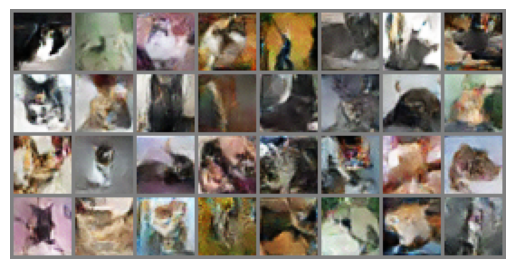

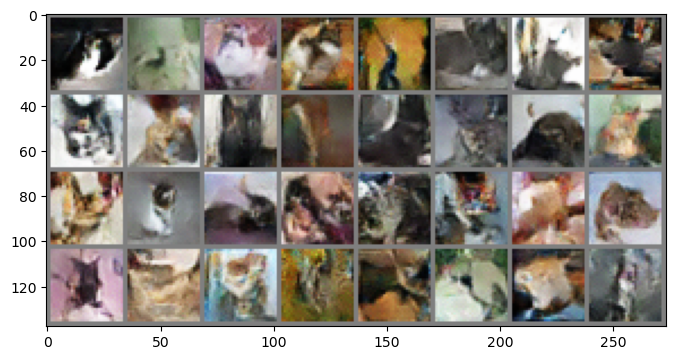

In [56]:
# for img in img_list:
#     imshow(img)

fig = plt.figure()
plt.axis("off")
ims = [[plt.imshow(np.transpose(i/2 + 0.5,(1,2,0)), animated=True)] for i in img_list]

plt.rcParams['animation.embed_limit'] = 1024 # mb
ani = animation.ArtistAnimation(fig, ims, interval=100, repeat_delay=5000, blit=True)
ani.save(path + '-output.gif')

HTML(ani.to_jshtml())

imshow(img_list[-1])

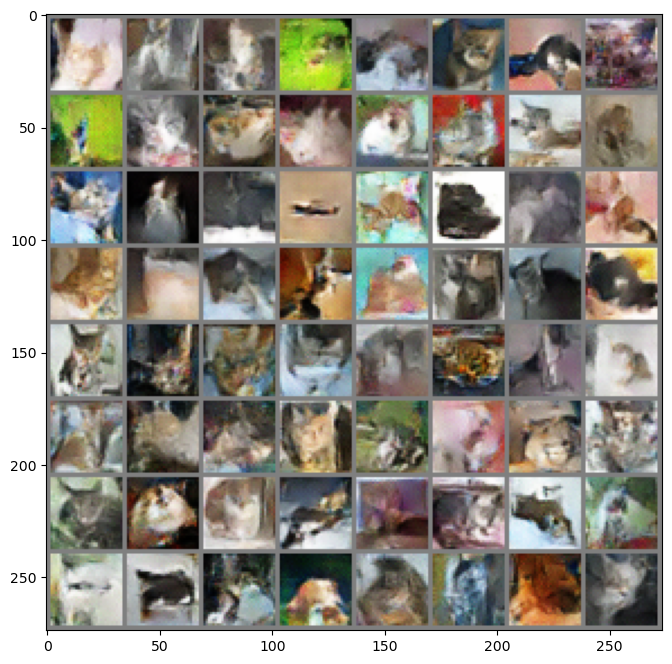

In [57]:
# print(torch.load("models/DCGAN/64ep_DLReLU-GReLU.pt"))
# path = "models/CatGAN/1024ep_64nf_128nz_DLReLU-GReLU-block2outngfx4-smoothing-shuffled-noised.pt"
gen = torch.Generator(device=device)
gen.seed()
noise = torch.randn(64, nz, 1, 1, device=device, generator=gen)

loaded = Generator(ngpu).to(device)
loaded.load_state_dict(torch.load(path))

loaded.eval()
out = loaded(noise).cpu()


imshow(torchvision.utils.make_grid(out))
imsave(torchvision.utils.make_grid(out), path)